# Churn Modeling

## Importing packages

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 2)

## import modeling data created in the Data Prep pipeline

In [2]:
import os
os.chdir("D:\Sunny_Personal\OSU MSBA\Fall 2019\BAN5561_CLV")
combined_df = pd.read_csv('combined_data.csv')

## Using the head method to preview our data:

In [3]:
combined_df.head()

,ST,Zip,DMA,Area_Cd,emailable,solicit_ph_ind,solicit_email_ind,fixd_incm_flg,scheduled_purchase_flg,months_since_last_trans,months_since_first_trans,purch_avg_interval,mail_cnt_36mo,call_in_mo_36mo,call_out_mo_36mo,tier,tier_prev,acct_ID,activation_date,event_date,churn_year_plus1_ind,log_order_cnt_36mo,log_purch_amt_36mo,log_purch_amt_life,log_purch_avg_36mo,...,ST_RI,ST_SC,ST_SD,ST_TN,ST_TX,ST_UT,ST_VA,ST_VI,ST_VT,ST_WA,ST_WI,ST_WV,ST_WY,ST_missing,tier_1-Bronze,tier_2-Silver,tier_3-Gold,tier_4-Platinum,tier_5-Diamond,tier_prev_1-Bronze,tier_prev_2-Silver,tier_prev_3-Gold,tier_prev_4-Platinum,tier_prev_5-Diamond,tier_prev_xxx
0,VA,23464,544,missing,0,0,1,0,0,2,128,2.93,4,0,0,3-Gold,xxx,B102465045,04JAN04,30JUN15,1,0.30,4.16,4.42,2.54,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
1,NC,27542,560,919,1,1,1,0,0,4,122,2.11,22,4,0,5-Diamond,3-Gold,B106897643,04JUL04,NaN,0,0.95,3.50,4.09,2.14,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
2,NV,89109,839,702,0,0,1,0,0,8,96,88.00,1,0,0,1-Bronze,xxx,B111832829,03SEP06,NaN,0,0.30,2.48,3.03,2.48,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,OH,43050,535,614,0,1,1,0,0,1,108,1.02,36,0,0,1-Bronze,xxx,B112883062,03SEP05,NaN,0,0.85,2.85,3.33,1.32,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,HI,96789,744,808,1,1,1,0,0,4,105,1.53,19,4,0,4-Platinum,3-Gold,B113581008,03DEC05,NaN,0,0.85,3.93,4.30,2.65,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


## Exploratory Data Analysis:
    
       1. Analyzing average values of numeric variables, by the levels of the target variable
       2. Descriptive Statistics


In [13]:

print("###########################################") 
print("          averages by churn ind            ")
print("##########################################\n") 

print('The average purchase amount between the churn and non-churn customers')
print(combined_df.groupby('churn_year_plus1_ind')['log_purch_amt_life'].mean())

print(' ')
print('The average scheduled purchases between the churn and non-churn customers')
print(combined_df.groupby('churn_year_plus1_ind')['scheduled_purchase_flg'].mean())

print(" ") 
print("The average months since last transaction between the churn and non-churn customers ") 
print(combined_df.groupby('churn_year_plus1_ind')['months_since_last_trans'].mean())

###########################################
          averages by churn ind            
##########################################

The average purchase amount between the churn and non-churn customers
churn_year_plus1_ind
0    3.00
1    2.48
Name: log_purch_amt_life, dtype: float64
 
The average scheduled purchases between the churn and non-churn customers
churn_year_plus1_ind
0    3.57e-01
1    5.34e-03
Name: scheduled_purchase_flg, dtype: float64
 
The average months since last transaction between the churn and non-churn customers 
churn_year_plus1_ind
0    1.76
1    6.11
Name: months_since_last_trans, dtype: float64


#### Descriptive Statistics

In [14]:
print(" summary stats on combined data ") 
print(combined_df.describe(include='all').transpose())

 summary stats on combined data 
                            count unique         top   freq     mean      std      min   25%      50%      75%      max
ST                          73384     59          CA   6641      NaN      NaN      NaN   NaN      NaN      NaN      NaN
Zip                         73384  18351     missing    282      NaN      NaN      NaN   NaN      NaN      NaN      NaN
DMA                         73384    216         803   3012      NaN      NaN      NaN   NaN      NaN      NaN      NaN
Area_Cd                     73384    328     missing   3849      NaN      NaN      NaN   NaN      NaN      NaN      NaN
emailable                 7.3e+04    NaN         NaN    NaN     0.52      0.5        0     0        1        1        1
solicit_ph_ind            7.3e+04    NaN         NaN    NaN     0.89     0.31        0     1        1        1        1
solicit_email_ind         7.3e+04    NaN         NaN    NaN     0.96     0.19        0     1        1        1        1
fixd_in

#### Dropping insignicant variablesand creating new version of data for modeling:

          1. Any categorical variable for which we create dummy indicators
           other variables we don't want in the model, or which don't make sense
           to be included in model training, we are dropping here

          2. We also want to drop acct_ID, but we are going to do that after partioning
             because we need acct_ID for partioned sets to for reference later         

In [15]:
x_train_df = combined_df.drop(['Zip','DMA','Area_Cd','activation_date','event_date',
                            'ST','tier','tier_prev'
                              ],axis=1)

x_train_df.shape

(73384, 103)

### Partitioning data into Training and Test sets
    
        Creating dataframes with just account IDs to be used to rejoin data later:

In [16]:
x_train_df, x_test_df = train_test_split(x_train_df, test_size = 0.30)

#will need the acct_IDs to rejoin data later,
#so pulling out now before dropping from actual model training data 

train_acct_IDs_df = x_train_df[['acct_ID']]
test_acct_IDs_df  = x_test_df[['acct_ID']]

#the target (or dependent) variable is stored in it's own dataframe
y_train_df = x_train_df[['churn_year_plus1_ind']]
y_test_df  = x_test_df[['churn_year_plus1_ind']]

#We want to drop acct_ID and the target variable from the dataframe of independent variables 
#We want to drop the target (future timeframe) variables for margin modeling               

x_train_df = x_train_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'],axis=1)

x_test_df = x_test_df.drop(['acct_ID','churn_year_plus1_ind', 'log_margin_Y_pos_1', 'margin_Y_pos_1'],axis=1)

x_train_df.shape

(51368, 99)

### Using Logistic Regression Model to select variables.


In [18]:
#models penalized with the L1 norm have sparse solutions: many of their estimated coefficients are zero
#SelectFromModel can be used to to select effects with non-zero coefficients 
#the parameter C controls the sparsity: the smaller C the fewer features selected

#using the ravel simply to avoid warning logs
y_train_array=np.ravel(y_train_df)


model1 = linear_model.LogisticRegression(C=0.01, solver='liblinear', penalty='l1', tol=0.01)
model1_fit = model1.fit(x_train_df, y_train_array)
model1_selects = SelectFromModel(model1_fit, prefit=True)


"""x_train_selected_df = model1_selects.transform(x_train_df)"""
#in lieu of commented-out transform method above,
#can use this method to explicitly define columns to keep
x_train_selected_df = x_train_df[x_train_df.columns[model1_selects.get_support()]]
x_test_selected_df  = x_test_df[x_test_df.columns[model1_selects.get_support()]]


In [19]:
coefficients = pd.DataFrame(model1_fit.coef_)
coefficients = np.transpose(coefficients[coefficients.columns[model1_selects.get_support()]])
coefficients = coefficients.reset_index(drop=True)
coefficients_match = pd.concat([pd.DataFrame(x_train_selected_df.columns),coefficients], axis = 1)
coefficients.shape 

(30, 1)

In [20]:
print(" ") 
print("Coefficients for selected variables")
coefficients_match.head(40)

 
Coefficients for selected variables


,0,0
0,emailable,-2.45e-02
1,solicit_ph_ind,-5.93e-02
2,solicit_email_ind,-3.63e-03
3,scheduled_purchase_flg,-3.46e+00
4,months_since_last_trans,4.01e-01
5,months_since_first_trans,-2.62e-03
6,purch_avg_interval,-2.46e-03
7,mail_cnt_36mo,-7.88e-03
8,call_in_mo_36mo,4.32e-04
9,call_out_mo_36mo,-1.54e-02


### Variable Reduction and Multicolinearity:

In [21]:
x_train_selected_df.shape

(51368, 30)

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=10):
    cols = X.columns
    variables = np.arange(X.shape[1])
    dropped=True
    while dropped:
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            variables = np.delete(variables, maxloc)
        else:
            dropped=False
    print('Remaining variables:')
    print(X.columns[variables])        
        
    return X.iloc[:, variables]

x_train_selected_df=calculate_vif_(x_train_selected_df, 10.0)
        
x_train_selected_df.shape

dropping 'log_margin_3yr_avg' at index: 26
dropping 'log_margin_Y_neg_2' at index: 24
dropping 'log_margin_Y_neg_3' at index: 24
dropping 'log_purch_amt_36mo' at index: 11
dropping 'log_margin_Y_neg_1' at index: 22
dropping 'log_purch_amt_life' at index: 11
dropping 'log_purch_cnt_tt_36mo' at index: 13
dropping 'log_purch_cnt_life' at index: 12
dropping 'perc_purch_ck_36mo' at index: 14
dropping 'solicit_email_ind' at index: 2
dropping 'log_purch_avg_36mo' at index: 10
dropping 'margin_3yr_avg' at index: 15
dropping 'tier_prev_xxx' at index: 17
Remaining variables:
Index(['emailable', 'solicit_ph_ind', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_order_cnt_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1', 'margin_Y_neg_2', 'tier_1-Bronze', 'tier_prev_1-Bronze'], dtype='object')


(51368, 17)

### Reducing test set to match train set


In [24]:
""" reducing the test set to have the same columns as the training set """

x_test_selected_df=x_test_selected_df[x_train_selected_df.columns]
print('Remaining variables in test set:')
print(x_test_selected_df.columns)
        
x_test_selected_df.shape

Remaining variables in test set:
Index(['emailable', 'solicit_ph_ind', 'scheduled_purchase_flg', 'months_since_last_trans', 'months_since_first_trans', 'purch_avg_interval', 'mail_cnt_36mo', 'call_in_mo_36mo', 'call_out_mo_36mo', 'log_order_cnt_36mo', 'log_resp_cnt_36mo', 'perc_purch_cc_36mo', 'perc_purch_et_36mo', 'margin_Y_neg_1', 'margin_Y_neg_2', 'tier_1-Bronze', 'tier_prev_1-Bronze'], dtype='object')


(22016, 17)

### Using the statsmodels package to view the output

In [25]:
## for the statsmodels, need to add a constant to fit intercept 

x_train_selected_df = sm.add_constant(x_train_selected_df, has_constant='add')
x_test_selected_df  = sm.add_constant(x_test_selected_df, has_constant='add')

#modeling with selected variables from steps above 

model = sm.Logit(y_train_df, x_train_selected_df)
result = model.fit(maxiter=100)

print(" ") 
print("Logistic model with selected variables")
print(" ") 
print(result.summary2())
print('AIC: ', result.aic)
print('BIC: ', result.bic)

Optimization terminated successfully.
         Current function value: 0.319917
         Iterations 9
 
Logistic model with selected variables
 
                             Results: Logit
Model:                Logit                 Pseudo R-squared:  0.445     
Dependent Variable:   churn_year_plus1_ind  AIC:               32903.0310
Date:                 2020-04-03 16:15      BIC:               33062.2729
No. Observations:     51368                 Log-Likelihood:    -16434.   
Df Model:             17                    LL-Null:           -29598.   
Df Residuals:         51350                 LLR p-value:       0.0000    
Converged:            1.0000                Scale:             1.0000    
No. Iterations:       9.0000                                             
-------------------------------------------------------------------------
                          Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------

C:\Users\Harish Patlolla\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Scoring the test data 

In [27]:
# """ predicted values using the model """
# """ using numpy copy to store result as an array """
# """ manually adding a column header """

predict_train = pd.DataFrame(np.copy(result.predict(x_train_selected_df)), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(result.predict(x_test_selected_df)), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))


AROC train:  0.9174373579588242
AROC test:  0.9187233722048544


In [28]:
#Resetting index to join the account IDs
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

#joining predicted and actuals 
train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)


In [33]:
print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))


print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error testn:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

 
MSE train: 0.10064754758345923
MSE test: 0.09986591848035152
mean squared error train: 0.10064754758345784
mean squared error testn: 0.09986591848035117


### Gradient Boosting Model

In [46]:
#Gradient Boosting
params = {'n_estimators': 500, 'min_samples_split': 2,  'max_depth': 5, 'learning_rate': 0.01}
gradient_boosting_clf = GradientBoostingClassifier(**params)

result = gradient_boosting_clf.fit(x_train_selected_df, y_train_array)

#calculating accuracy on the test data
accuracy = gradient_boosting_clf.score(x_test_selected_df, y_test_df)
print("GB overall accuracy:", accuracy)

In [47]:

#storing the predicted probabilites of churn in train and test data
predict_train = pd.DataFrame(np.copy(gradient_boosting_clf.predict_proba(x_train_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])
predict_test = pd.DataFrame(np.copy(gradient_boosting_clf.predict_proba(x_test_selected_df)[:, 1]), columns=["P_churn_year_plus1_ind"])

print ('AROC train: ', metrics.roc_auc_score(y_train_df, predict_train))
print ('AROC test: ', metrics.roc_auc_score(y_test_df, predict_test))


AROC train:  0.940870549112879
AROC test:  0.9348520774234702


In [49]:

#resetting index to join the account IDs
y_train_df = y_train_df.reset_index(drop=True)
y_test_df = y_test_df.reset_index(drop=True)

train_accounts = train_acct_IDs_df.reset_index(drop=True)
pred_v_actual_train = y_train_df.join(predict_train)
pred_v_actual_train = pred_v_actual_train.join(train_accounts)

test_accounts = test_acct_IDs_df.reset_index(drop=True)
pred_v_actual_test = y_test_df.join(predict_test)
pred_v_actual_test = pred_v_actual_test.join(test_accounts)

print(" ") 
print("MSE train:", mean_squared_error(y_train_df, predict_train))
print("MSE test:", mean_squared_error(y_test_df, predict_test))

print(" ") 
print("testing that the joining process works. if so, these MSE should match the ones above.")
print("mean squared error train:" , (np.mean((pred_v_actual_train['churn_year_plus1_ind']-pred_v_actual_train['P_churn_year_plus1_ind'])**2)))
print("mean squared error test:" , (np.mean((pred_v_actual_test['churn_year_plus1_ind']-pred_v_actual_test['P_churn_year_plus1_ind'])**2)))

#Plotting ROC curve
y_traint_array = y_train_df.values
y_test_array = y_test_df.values

test_AROC  = np.zeros((params['n_estimators'],), dtype=np.float64)
train_AROC = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(gradient_boosting_clf.staged_predict_proba(x_test_selected_df)):
    test_AROC[i] = metrics.roc_auc_score(y_test_array, y_pred[:, 1])

for i, y_pred in enumerate(gradient_boosting_clf.staged_predict_proba(x_train_selected_df)):
    train_AROC[i] = metrics.roc_auc_score(y_train_array, y_pred[:, 1])



 
MSE train: 0.08445208390737881
MSE test: 0.08857621935041637
 
testing that the joining process works. if so, these MSE should match the ones above.
mean squared error train: 0.08445208390737824
mean squared error test: 0.08857621935041626


Text(0,0.5,'AROC')

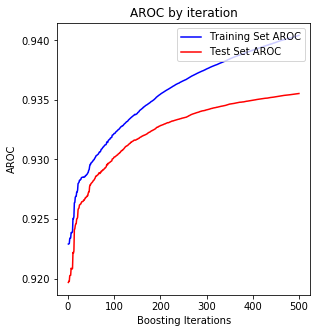

In [62]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('AROC by iteration')
plt.plot(np.arange(params['n_estimators']) + 1, train_AROC, 'b-',
         label='Training Set AROC')
plt.plot(np.arange(params['n_estimators']) + 1, test_AROC, 'r-',
         label='Test Set AROC')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('AROC')

### Feature Importance for the Gradient Boosting Model:

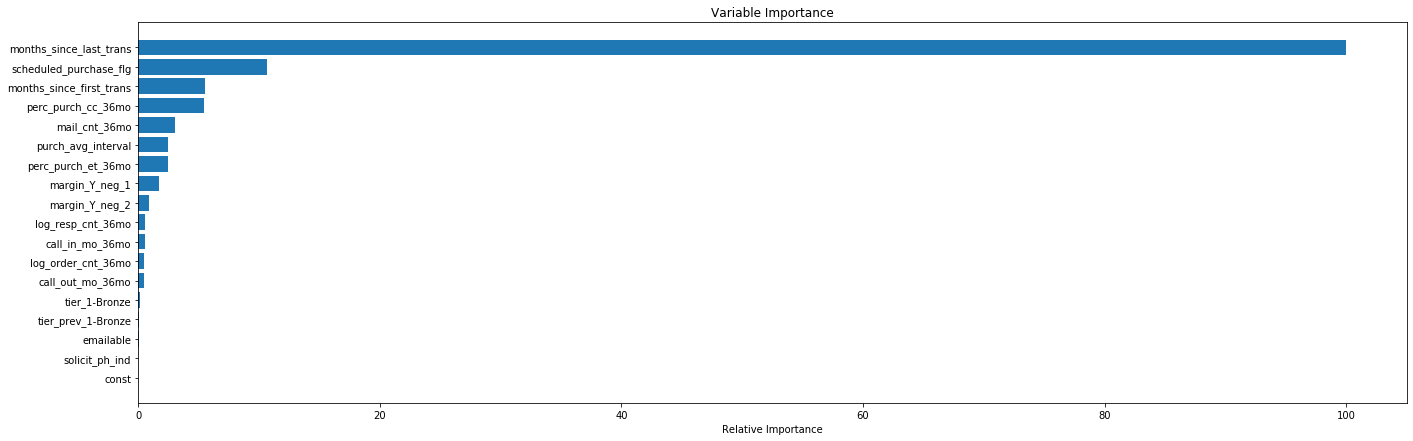

In [50]:
feature_importance = gradient_boosting_clf.feature_importances_
""" make importances relative to max importance """
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(50,7))
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train_selected_df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

    ### Appending the train and test sets
    ### keeping the acct_IDs 
    ### predicted churn probabilities

In [52]:
pred_v_actual_train=pred_v_actual_train.append(pred_v_actual_test, ignore_index=True)
pred_v_actual_train = pred_v_actual_train.drop(['churn_year_plus1_ind'],axis=1)
pred_v_actual_train.to_csv('churn_scores.csv',index=False)
pred_v_actual_train.shape

C:\Users\Harish Patlolla\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


(95400, 2)